In [1]:
from time import time
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np
import torch
import pypolo
import gpytorch
from pypolo.scalers import MinMaxScaler, StandardScaler
import yaml
from PIL import Image



In [2]:

def set_random_seed(seed):
    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)
    print(f"Set random seed to {seed} in numpy and torch.")
    return rng


def get_environment(cfg, filepath="./data/n44w111.npz"):
    with np.load(filepath) as data:
        env = data["arr_0"]
    print(f"Loaded environment of shape {env.shape}.")
    return env

def get_environment_from_image(cfg, png_path, resize=None, max_height=None):
    
    image = Image.open(png_path)

    if resize is not None:
        if not isinstance(resize, tuple):
            raise TypeError
        else:
            resized_image = image.resize(resize, Image.BOX)
            image = resized_image.convert('L') 
    
    env = np.array(image)
    
    if max_height is not None:
        
        if not isinstance(max_height, float):
            raise TypeError
        else:
            min_value = np.min(env)
            max_value = np.max(env)
            normalized_matrix = (env - min_value) / (max_value - min_value)
            env = normalized_matrix * max_height
            
    print(f"Loaded environment of shape {env.shape}.")
    return env


def get_sensor(cfg, env, rng):
    sensor = pypolo.sensors.PointSensor(
        matrix=env,
        env_extent=cfg.env_extent,
        rate=cfg.sensing_rate,
        noise_scale=cfg.noise_scale,
        rng=rng,
    )
    print(
        f"Initialized sensor with rate {cfg.sensing_rate} and noise scale {cfg.noise_scale}."
    )
    return sensor


def get_robot(cfg, sensor):
    robot = pypolo.robots.DiffDriveRobot(
        sensor=sensor,
        state=np.array([cfg.task_extent[1], cfg.task_extent[2], -np.pi]),
        control_rate=cfg.control_rate,
        max_lin_vel=cfg.max_lin_vel,
        max_ang_vel=cfg.max_ang_vel,
        goal_radius=cfg.goal_radius,
    )
    print(f"Initialized robot with control rate {cfg.control_rate}.")
    return robot


def get_visualizer(cfg, env):
    visualizer = pypolo.utils.Visualizer(
        cfg.env_extent, cfg.task_extent, cfg.plot_robot_interval
    )
    vmin, vmax = np.min(env), np.max(env)
    visualizer.vmins[1], visualizer.vmaxs[1] = vmin, vmax
    visualizer.plot_image(
        index=0, matrix=env, title="Ground Truth", vmin=vmin, vmax=vmax
    )
    print(f"Initialized visualizer.")
    return visualizer


def pilot_survey(cfg, robot, rng):
    bezier_planner = pypolo.planners.BezierPlanner(cfg.task_extent, rng)
    goals = bezier_planner.plan(num_points=cfg.num_bezier_points)
    robot.goals = goals
    while len(robot.goals) > 0:
        robot.step()
    x_init, y_init = robot.commit_samples()
    print(f"Collected {len(x_init)} samples in pilot survey.")
    return x_init, y_init


def get_model(cfg, x_init, y_init, x_scaler, y_scaler):
    if cfg.kernel.name == "RBF":
        kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        kernel.base_kernel.lengthscale = cfg.kernel.lengthscale
        kernel.outputscale = cfg.kernel.outputscale
    elif cfg.kernel.name == "AK":
        kernel = gpytorch.kernels.ScaleKernel(
            pypolo.models.gp.kernels.AttentiveKernel(
                dim_input=x_init.shape[1],
                dim_hidden=cfg.kernel.dim_hidden,
                dim_output=cfg.kernel.dim_output,
                min_lengthscale=cfg.kernel.min_lengthscale,
                max_lengthscale=cfg.kernel.max_lengthscale,
            )
        )
    else:
        raise ValueError(f"Unknown kernel: {cfg.kernel}")
    if cfg.model.name == "GPR":
        model = pypolo.models.gp.GPRModel(
            x_train=x_init,
            y_train=y_init,
            x_scalar=x_scaler,
            y_scalar=y_scaler,
            kernel=kernel,
            noise_var=cfg.model.noise_var,
            num_sparsification=cfg.model.num_sparsification,
        )
    else:
        raise ValueError(f"Unknown model: {cfg.model.name}")
    print(f"Initialized model {cfg.model.name} with kernel {cfg.kernel.name}.")
    return model


def get_planner(cfg, rng):
    if cfg.planner.name == "MaxEntropy":
        planner = pypolo.planners.MaxEntropyPlanner(
            cfg.task_extent, rng, cfg.planner.num_candidates
        )
    else:
        raise ValueError(f"Unknown planner: {cfg.planner.name}")
    print(f"Initialized planner {cfg.planner.name}.")
    return planner


def model_update(num_steps, model, evaluator):
    # print("Optimization...")
    start = time()
    losses = model.optimize(num_steps=num_steps) #calculate lossses
    end = time()
    evaluator.training_times.append(end - start)
    evaluator.losses.extend(losses)


def evaluation(model, evaluator):
    # print(f"Prediction...")
    start = time()
    mean, std = model.predict(evaluator.eval_inputs)
    end = time()
    evaluator.prediction_times.append(end - start)
    evaluator.compute_metrics(mean, std)


def visualization(visualizer, evaluator, x_inducing=None):
    # print(f"Visualization...")
    visualizer.plot_prediction(evaluator.mean, evaluator.std, evaluator.abs_error)
    visualizer.plot_data(evaluator.x_train)
    if x_inducing is not None:
        print("Plotting inducing inputs...")
        visualizer.plot_inducing_inputs(x_inducing)
    visualizer.plot_metrics(evaluator)


def information_gathering(robot, model, planner, visualizer):
    
    print("Run information_gathering()------------------")
    
    while True:
        # print("Planning...")
        print("Current State: " ,robot.state[:2])
        goal = planner.plan(model, robot.state[:2])
        
        visualizer.plot_goal(goal)
        robot.goals = goal
        
        print("Desired goal from planner.plan(): " ,robot.goals)
        
        visualizer.pause()
        plot_counter = 0
        
        print("Sampling...")
        while robot.has_goals:
            
            print("state: " ,robot.state)
            
            plot_counter += 1
            robot.step()
            if visualizer.interval > 0 and plot_counter % visualizer.interval == 0:
                visualizer.plot_robot(robot.state)
                visualizer.pause()
        if len(robot.sampled_observations) > 0:
            print("Append Sample Elevation: ", robot.sampled_observations)
            print("corresponding Sample Location: ", robot.sampled_locations)
            x_new, y_new = robot.commit_samples()
            print("End information_gathering()------------------")
            return x_new, y_new

In [3]:
class Struct(object):
    def __init__(self, d):
        for k, v in d.items():
            
            k = k.replace("-","_")
            
            #Setting default configuration
            if k == 'defaults':
                parsed_list = eval(str(v))
                
                for item in parsed_list:
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if key == '_self_':
                                pass
                            elif key == 'model':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'planner':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'kernel':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            else:
                                setattr(self, key.replace("/", "_").replace(" ","_"), Struct(value) if isinstance(value, dict) else value)
                            
            else:
                
                #Add other struct argument
                if isinstance(k, (list, tuple)):
                    setattr(self, k, [Struct(x) if isinstance(x, dict) else x for x in v])
                else:
                    setattr(self, k, Struct(v) if isinstance(v, dict) else v)
                
            
                

with open('./configs/main.yaml') as info:
    args = yaml.load(info)
    
print(args)
cfg = Struct(args)

{'seed': 0, 'env_extent': [-11.0, 11.0, -11.0, 11.0], 'task_extent': [-10.0, 10.0, -10.0, 10.0], 'eval_grid': [30, 30], 'sensing_rate': 0.5, 'noise_scale': 1.0, 'control_rate': 10.0, 'max_lin_vel': 0.5, 'max_ang_vel': 1.0, 'goal_radius': 0.1, 'num_bezier_points': 50, 'num_train_steps': 10, 'max_num_samples': 800, 'plot_robot_interval': 10, 'defaults': [{'model': 'gpr'}, {'kernel': 'ak'}, {'planner': 'max_entropy'}, {'override hydra/hydra_logging': 'disabled'}, {'override hydra/job_logging': 'disabled'}, '_self_'], 'hydra': {'output_subdir': None, 'run': {'dir': '.'}}}


In [4]:
env_path = '/home/kmuenpra/Desktop/terrains/terrain_n38_w087_1arc_v2.png'

rng = set_random_seed(cfg.seed)
max_height = 0.3
env = get_environment_from_image(cfg, png_path=env_path, resize=(50,50), max_height=max_height)

Set random seed to 0 in numpy and torch.
Loaded environment of shape (50, 50).


In [5]:
cfg.noise_scale = 0.1 * max_height

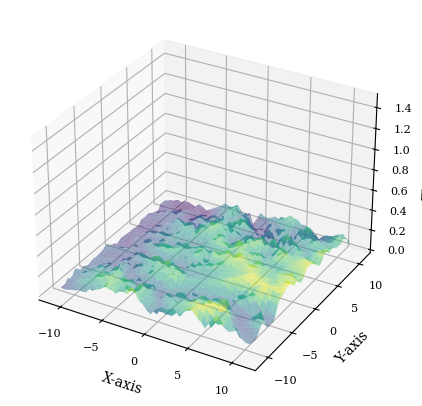

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
    

# # Create a meshgrid for X and Y coordinates
xi = np.linspace(cfg.env_extent[0] , cfg.env_extent[1], env.shape[0])
yi = np.linspace(cfg.env_extent[2], cfg.env_extent[3], env.shape[1])
X, Y = np.meshgrid(xi, yi)

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
# ax.plot_surface(xnew, ynew, znew, cmap='viridis', alpha=0.5, label='Interpolated Surface')
ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

Initialized visualizer.


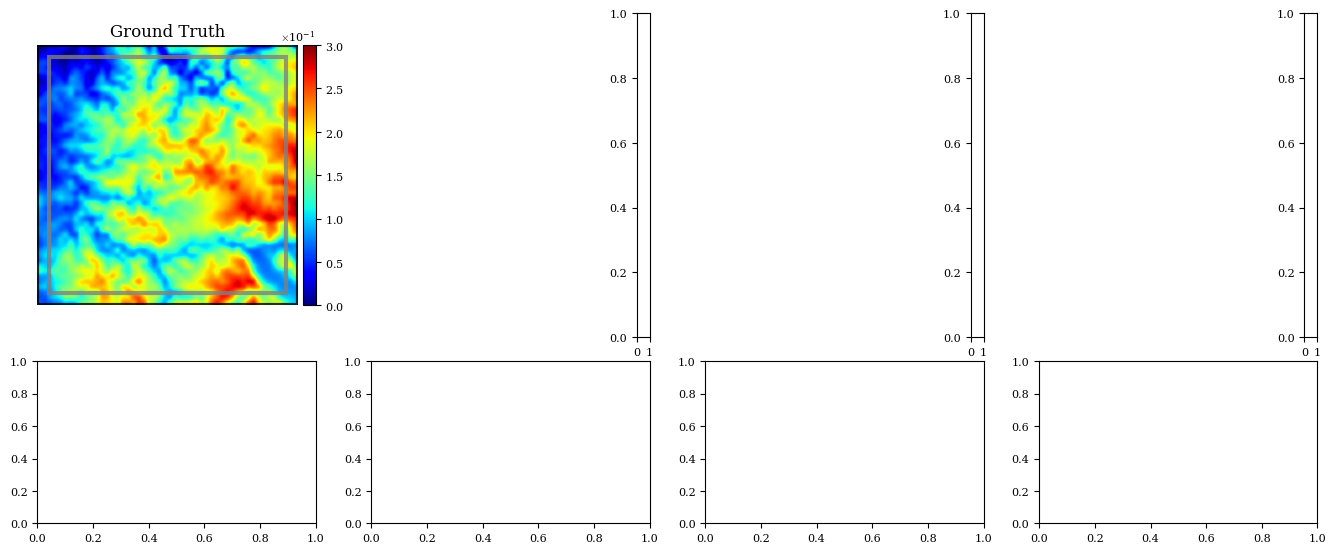

In [7]:
visualizer = get_visualizer(cfg, env)

In [8]:
#Setup sensors with noise, and set the environement coordinate to the env_extent
sensor =  get_sensor(cfg, env, rng)
sensor.matrix

Initialized sensor with rate 0.5 and noise scale 0.03.


array([[0.06553398, 0.05679612, 0.06262136, ..., 0.13398058, 0.10485437,
        0.10048544],
       [0.05970874, 0.05825243, 0.09174757, ..., 0.09757282, 0.09902913,
        0.08737864],
       [0.06262136, 0.07427184, 0.07427184, ..., 0.08446602, 0.08446602,
        0.08300971],
       ...,
       [0.03786408, 0.0407767 , 0.02912621, ..., 0.17038835, 0.17038835,
        0.17475728],
       [0.01601942, 0.01747573, 0.04223301, ..., 0.16456311, 0.16019417,
        0.14271845],
       [0.00436893, 0.        , 0.02621359, ..., 0.16747573, 0.12378641,
        0.05679612]])

In [9]:
#Evaluator for calculate and keep track of SMSES, RMSES, MAES, MSLLS, NLPDS (refer to the Paper)

evaluator = pypolo.utils.Evaluator(sensor, cfg.task_extent, cfg.eval_grid)

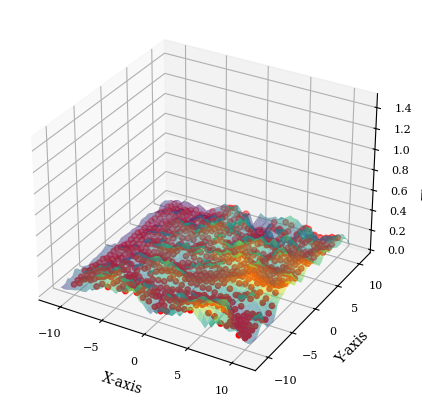

In [10]:
# Create a 3D plot for evaluatinf points
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
ax.scatter(evaluator.eval_inputs[:,0],evaluator.eval_inputs[:,1],evaluator.eval_outputs,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

In [11]:
evaluator.eval_inputs.shape

(900, 2)

In [12]:
robot =  get_robot(cfg, sensor)
planner =  get_planner(cfg, rng)

Initialized robot with control rate 10.0.
Initialized planner MaxEntropy.


In [13]:
sensor.state

array([ 10.        , -10.        ,  -3.14159265])

In [14]:
x_init, y_init =  pilot_survey(cfg, robot, rng)
x_scaler = MinMaxScaler()
x_scaler.fit(x_init) #find min/max of (x1,x2) coordinates
y_scaler = StandardScaler()
y_scaler.fit(y_init) #find mean and std of y_init
evaluator.add_data(x_init, y_init) #set training data

From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]]), array([[0.17936214]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]]), array([[0.17936214]]), array([[0.28130447]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]]), array([[0.17936214]]), array([[0.28130447]]), array([[0.33272577]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]]), array([[0.17936214]]), array([[0.28130447]]), array([[0.33272577]]), array([[0.19932244]])]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.16942642]]), array([[0.16054841]]), array([[0.17936214]]), array([[0.28130447]]), array([[0.33

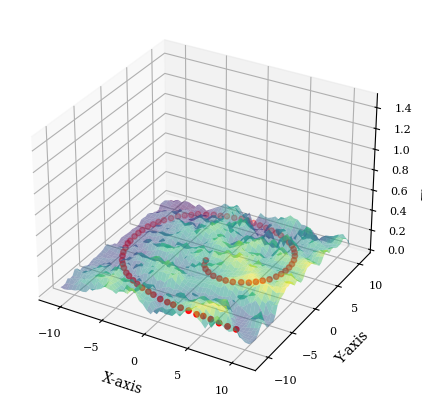

In [15]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,env,cmap='viridis', alpha=0.5)
ax.scatter(x_init[:,0],x_init[:,1],y_init*y_scaler.actual_std +y_scaler.actual_mean ,color='red', s=15)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 1.5])

plt.show()

In [16]:
model = get_model(cfg, x_init, y_init, x_scaler, y_scaler)

Model parameters:
Fast lr: 0.01 likelihood.noise_covar.raw_noise torch.Size([1])
Fast lr: 0.01 covar_module.raw_outputscale torch.Size([])
Slow lr: 0.001 covar_module.base_kernel.nn.0.weight torch.Size([10, 2])
Slow lr: 0.001 covar_module.base_kernel.nn.0.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.2.bias torch.Size([10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.weight torch.Size([10, 10])
Slow lr: 0.001 covar_module.base_kernel.nn.4.bias torch.Size([10])
Initialized model GPR with kernel AK.


In [17]:
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

gpr_model.py >> optimize():
output = self.model(self.train_x):  MultivariateNormal(loc: torch.Size([76]))
self.train_y =  tensor([ 0.4877,  0.3533,  0.6381,  2.1815,  2.9600,  0.9403,  1.6393,  0.8083,
         0.6979,  0.4241, -0.9537,  0.5234,  1.1566,  0.3150,  0.1967,  0.2790,
         0.1005, -0.6933, -0.1052,  0.0041, -1.7156, -0.7002, -0.7588, -1.2900,
         0.2543, -1.5914, -1.1747, -0.9057, -0.6536,  0.0231, -1.4558, -0.9796,
        -1.4884, -1.6321, -0.7361, -1.1245, -1.0115,  0.2105, -1.4375, -0.2304,
        -1.3851, -0.1427, -0.9342,  0.9252,  0.4251, -1.3062, -1.5881, -1.4156,
        -1.8403, -1.0937, -0.6321,  0.0165, -0.3030,  0.5393,  0.5997,  0.5204,
         1.0616,  0.9703,  0.6992,  1.0430,  0.6378,  0.3389,  0.2872, -0.0172,
         1.1781,  1.3781,  0.8422,  1.7046,  0.6854,  0.7684,  0.7893,  0.4065,
         0.6890,  0.0957,  0.3983,  0.1030], dtype=torch.float64)
losses [1.2894079216471723, 1.2871222856246864, 1.284843324618856, 1.2825713104074012, 1.280

In [18]:
evaluation(model, evaluator)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

smses [0.6298385746282881]
rmses [0.04819102201615073]
maes [0.039809754480156834]
mslls [-0.09033835594505932]
nlpds [-1.4626598827537904]


In [19]:
x_new, y_new = information_gathering(robot, model, planner, visualizer)

Run information_gathering()------------------
Current State:  [-0.01797358 -0.07892011]
Desired goal from planner.plan():  [[-2.09533513  2.18187796]]


<Figure size 640x480 with 0 Axes>

Sampling...
state:  [-0.01797358 -0.07892011  1.56658201]
state:  [-0.01776287 -0.02892069  1.64131733]
state:  [-0.02128599  0.02095496  1.70969936]
state:  [-0.02820883  0.07047333  1.77229782]
state:  [-0.03821585  0.11946166  1.82962786]
state:  [-0.0510134   0.16779612  1.88215594]
state:  [-0.06633106  0.21539199  1.9303049 ]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.11108103]])]
state:  [-0.08392176  0.26219546  1.97445845]
state:  [-0.10356119  0.30817688  2.0149651 ]
state:  [-0.12504655  0.35332527  2.05214164]


<Figure size 640x480 with 0 Axes>

state:  [-0.14819514  0.39764389  2.08627622]
state:  [-0.17284275  0.44114668  2.11763112]
state:  [-0.19884204  0.48385538  2.14644517]
state:  [-0.22606098  0.52579731  2.17293598]
state:  [-0.25438131  0.56700355  2.19730191]
state:  [-0.28369715  0.60750756  2.21972384]
state:  [-0.31391372  0.64734412  2.24036676]
state:  [-0.34494612  0.68654847  2.25938126]
state:  [-0.3767183   0.72515567  2.27690481]
state:  [-0.40916208  0.76320019  2.29306292]


<Figure size 640x480 with 0 Axes>

state:  [-0.44221629  0.80071549  2.30797025]
state:  [-0.47582602  0.83773385  2.32173158]
state:  [-0.50994191  0.87428613  2.33444268]
state:  [-0.54451957  0.91040174  2.34619109]
state:  [-0.57951903  0.94610852  2.35705691]
state:  [-0.61490424  0.98143276  2.36711339]
state:  [-0.6506427   1.01639916  2.37642759]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.11108103]]), array([[0.11952826]])]
state:  [-0.68670501  1.05103091  2.38506089]
state:  [-0.72306458  1.08534969  2.39306953]
state:  [-0.75969732  1.11937571  2.40050501]


<Figure size 640x480 with 0 Axes>

state:  [-0.79658136  1.15312777  2.40741457]
state:  [-0.83369679  1.18662334  2.4138415 ]
state:  [-0.87102547  1.21987855  2.41982556]
state:  [-0.90855076  1.25290828  2.42540323]
state:  [-0.94625738  1.28572618  2.43060805]
state:  [-0.98413115  1.31834467  2.43547086]
state:  [-1.02215884  1.35077497  2.44002003]
state:  [-1.0603279   1.38302708  2.44428173]
state:  [-1.09862628  1.4151097   2.44828009]
state:  [-1.13704208  1.44703018  2.45203742]


<Figure size 640x480 with 0 Axes>

state:  [-1.17556329  1.47879433  2.45557439]
state:  [-1.21417735  1.51040626  2.45891017]
state:  [-1.25287061  1.54186805  2.46206261]
state:  [-1.29162772  1.57317932  2.46504837]
state:  [-1.33043075  1.60433667  2.46788309]
state:  [-1.3692581   1.63533293  2.47058149]
state:  [-1.40808303  1.66615609  2.47315756]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.11108103]]), array([[0.11952826]]), array([[0.1210281]])]
state:  [-1.44687187  1.69678803  2.47562463]
state:  [-1.48558163  1.72720277  2.47799555]
state:  [-1.52415706  1.75736431  2.48028281]


<Figure size 640x480 with 0 Axes>

state:  [-1.56252708  1.78722409  2.48249872]
state:  [-1.60060063  1.81671791  2.4846555 ]
state:  [-1.63826202  1.84576271  2.48676553]
state:  [-1.67536653  1.87425338  2.48884141]
state:  [-1.71173687  1.9020605   2.49089624]
state:  [-1.74716206  1.92902984  2.4929437 ]
state:  [-1.78140048  1.95498512  2.49499826]
state:  [-1.81418886  1.97973525  2.49707523]
state:  [-1.84525831  2.00308671  2.4991909 ]
state:  [-1.87435654  2.02486044  2.50136247]


<Figure size 640x480 with 0 Axes>

state:  [-1.90127291  2.04491049  2.50360798]
state:  [-1.92586087  2.0631404   2.50594622]
state:  [-1.94805211  2.07951306  2.50839646]
state:  [-1.96785908  2.09405181  2.51097838]
state:  [-1.98536632  2.10683307  2.51371186]
state:  [-2.000714    2.11797355  2.516617  ]
state:  [-2.0140787   2.12761548  2.51971408]
From base_robot.py>>step() --> Got new sample elevation:  [array([[0.11108103]]), array([[0.11952826]]), array([[0.1210281]]), array([[0.12663885]])]
Append Sample Elevation:  [array([[0.11108103]]), array([[0.11952826]]), array([[0.1210281]]), array([[0.12663885]])]
corresponding Sample Location:  [[-0.0839217610118394, 0.26219546162578056], [-0.6867050056384156, 1.0510309148278063], [-1.44687187261782, 1.696788034010317], [-2.025655309642639, 2.135913000009487]]
End information_gathering()------------------


In [23]:
sensor.get(np.array([-0.01797359]) ,np.array([-0.07892011]))

array([0.10194175])

In [30]:
sensor.xs_to_cols(np.array([-9.342343]))

array([3])

In [20]:
print("New collect sample X: ", x_new)
print("New collect observation: ", y_new)
robot.goals

New collect sample X:  [[-0.08392176  0.26219546]
 [-0.68670501  1.05103091]
 [-1.44687187  1.69678803]
 [-2.02565531  2.135913  ]]
New collect observation:  [[0.11108103]
 [0.11952826]
 [0.1210281 ]
 [0.12663885]]


array([], shape=(0, 2), dtype=float64)

In [21]:
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

training x size torch.Size([76, 2])
training y size torch.Size([76])


In [22]:
model.add_data(x_new, y_new)
print("training x size", model.train_x.shape)
print("training y size",model.train_y.shape)

training x size torch.Size([80, 2])
training y size torch.Size([80])


In [23]:
model_update(cfg.num_train_steps, model, evaluator)
print("losses", evaluator.losses)
print("training time", evaluator.training_times)

gpr_model.py >> optimize():
output = self.model(self.train_x):  MultivariateNormal(loc: torch.Size([80]))
self.train_y =  tensor([ 0.4877,  0.3533,  0.6381,  2.1815,  2.9600,  0.9403,  1.6393,  0.8083,
         0.6979,  0.4241, -0.9537,  0.5234,  1.1566,  0.3150,  0.1967,  0.2790,
         0.1005, -0.6933, -0.1052,  0.0041, -1.7156, -0.7002, -0.7588, -1.2900,
         0.2543, -1.5914, -1.1747, -0.9057, -0.6536,  0.0231, -1.4558, -0.9796,
        -1.4884, -1.6321, -0.7361, -1.1245, -1.0115,  0.2105, -1.4375, -0.2304,
        -1.3851, -0.1427, -0.9342,  0.9252,  0.4251, -1.3062, -1.5881, -1.4156,
        -1.8403, -1.0937, -0.6321,  0.0165, -0.3030,  0.5393,  0.5997,  0.5204,
         1.0616,  0.9703,  0.6992,  1.0430,  0.6378,  0.3389,  0.2872, -0.0172,
         1.1781,  1.3781,  0.8422,  1.7046,  0.6854,  0.7684,  0.7893,  0.4065,
         0.6890,  0.0957,  0.3983,  0.1030, -0.3957, -0.2678, -0.2451, -0.1601],
       dtype=torch.float64)
losses [1.2894079216471723, 1.2871222856246864, 1

In [27]:
#scale back to actual elevation value
y_scaler.postprocess_mean(model.train_y)

tensor([[0.1694, 0.1605, 0.1794, 0.2813, 0.3327, 0.1993, 0.2455, 0.1906, 0.1833,
         0.1652, 0.0742, 0.1718, 0.2136, 0.1580, 0.1502, 0.1556, 0.1439, 0.0914,
         0.1303, 0.1375, 0.0239, 0.0910, 0.0871, 0.0520, 0.1540, 0.0321, 0.0596,
         0.0774, 0.0940, 0.1387, 0.0411, 0.0725, 0.0389, 0.0294, 0.0886, 0.0629,
         0.0704, 0.1511, 0.0423, 0.1220, 0.0457, 0.1278, 0.0755, 0.1983, 0.1653,
         0.0509, 0.0323, 0.0437, 0.0157, 0.0650, 0.0955, 0.1383, 0.1172, 0.1728,
         0.1768, 0.1716, 0.2073, 0.2013, 0.1834, 0.2061, 0.1793, 0.1596, 0.1562,
         0.1361, 0.2150, 0.2282, 0.1928, 0.2498, 0.1825, 0.1880, 0.1893, 0.1641,
         0.1827, 0.1435, 0.1635, 0.1440, 0.1111, 0.1195, 0.1210, 0.1266]],
       dtype=torch.float64)

In [28]:
evaluation(model, evaluator)

print("smses", evaluator.smses)
print("rmses", evaluator.rmses)
print("maes", evaluator.maes)
print("mslls", evaluator.mslls)
print("nlpds", evaluator.nlpds)

smses [0.6298385746282881, 0.644582002655399]
rmses [0.04819102201615073, 0.048751793425780406]
maes [0.039809754480156834, 0.04030321603776906]
mslls [-0.09033835594505932, -0.1114808117044845]
nlpds [-1.4626598827537904, -1.4838023385132153]


In [29]:
decision_epoch = 0
start_time = time()
time_elapsed = time() - start_time
decision_epoch += 1
visualizer.plot_title(decision_epoch, time_elapsed)
x_new, y_new = information_gathering(robot, model, planner, visualizer)
evaluator.add_data(x_new, y_new)
model.add_data(x_new, y_new)
model_update(cfg.num_train_steps, model, evaluator)
evaluation(model, evaluator)
visualizer.clear()
if cfg.kernel.name == "AK":
    visualizer.plot_lengthscales(
        model, evaluator, cfg.kernel.min_lengthscale, cfg.kernel.max_lengthscale
    )
visualization(visualizer, evaluator)
visualizer.pause()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
plt.show()